# ML Project: Classification 

## Predict what feature has more influence over income 

- Education vs Salary
- Sex vs Salary 

$50K/yr based on census data

Authors:
`Andrea Murphy` and `Josh Quigley`

## Setup

In [1]:
%matplotlib inline
import random

import pandas as pd
from pandas import Series,DataFrame
import numpy as np

import matplotlib.pyplot as plt
from time import time
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

In [2]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


In [3]:
import pylab as plot
params = { 
    "axes.labelsize": "large",
    "xtick.labelsize" : "x-large",
    "legend.fontsize": 20,
    "figure.dpi": 150,
    "figure.figsize" : [25, 7]
}
plot.rcParams.update(params)

In [4]:

data = pd.read_csv('data/adult.data.txt')
test_data = pd.read_csv('data/adult.test.txt') 

data.columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status", "occupation", "relationship", "race",
                           "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "salary"]
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,0


In [5]:
# This dataset has 32,559 records

data.tail()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
32555,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,0
32556,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,1
32557,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,0
32558,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,0
32559,52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,1


In [6]:
type(data.index)

pandas.core.indexes.range.RangeIndex

In [7]:
# Check to see if there are nulls

data.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
salary            0
dtype: int64

# Education (and Age) vs Salary 

In [8]:
# drop columns won't be useful in analysis and prediction
data_education = data.drop(['fnlwgt', 'hours-per-week', 'native-country', 'sex', 'race', 'education', 'relationship', 'occupation', 'marital-status', 'workclass', 'capital-gain', 'capital-loss'], axis=1)

In [9]:
# sample 10000 random entries to train
data_education = data_education.sample(n=10000)

In [10]:
#Let's see what's left
data_education.head()

,age,education-num,salary
17042,36,10,0
19227,57,9,0
20780,26,10,0
5633,51,14,1
6950,26,11,0


In [11]:
data_education.shape

(10000, 3)

In [12]:
# The 3 largest categories are Highschool Graduates (education-num 9),
# Some College Education (education-num 10), and Bachelors Degrees (education-num 13). 

data_education["education-num"].value_counts()

9     3291
10    2185
13    1638
14     570
11     419
7      343
12     332
6      289
4      200
15     176
5      136
16     125
8      124
3      106
2       51
1       15
Name: education-num, dtype: int64

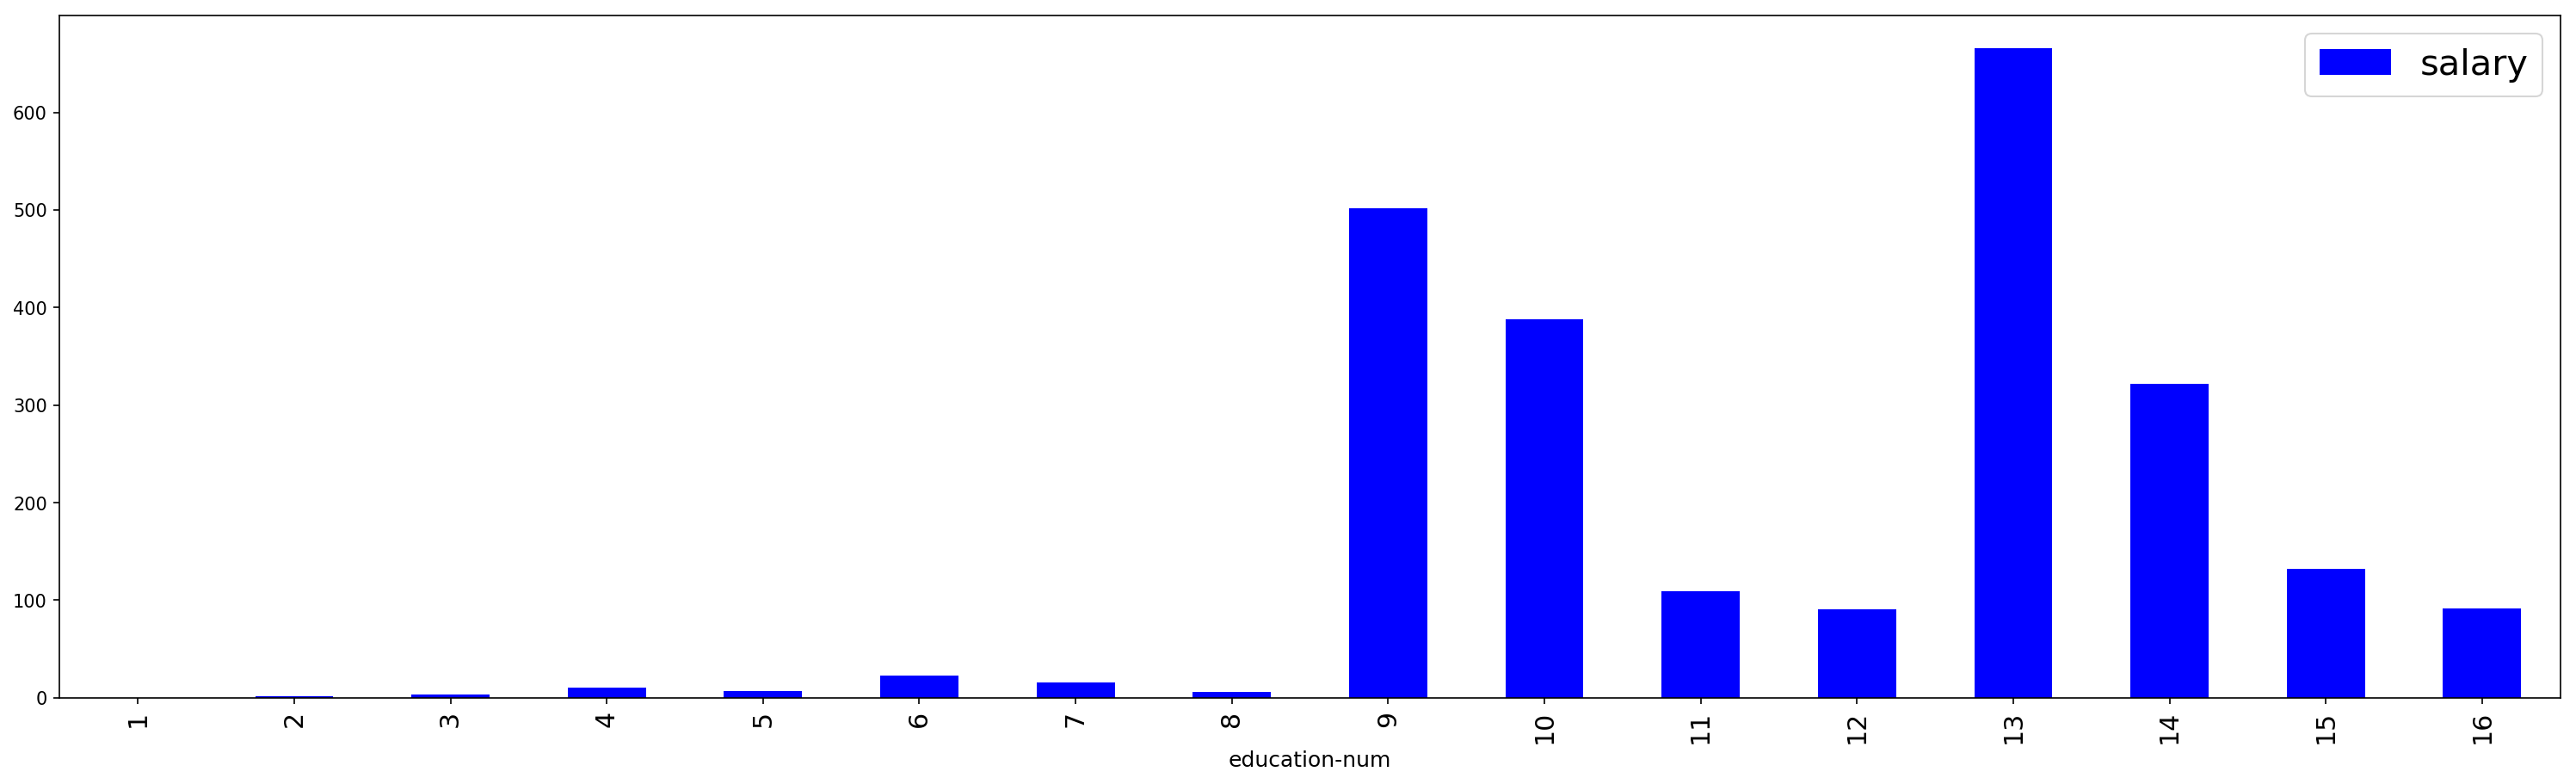

In [13]:
#Bar graph exploring which education groups are making $50,000 or more.

data_education.groupby('education-num').agg('sum')[['salary']].plot(kind='bar', figsize=(25, 7),
                                                          stacked=True, color=['b', 'r']);

In [14]:
#X Train and y-train have 70000 records of education-num and age and y-train has 70000 records of salary.
#X Test has 3000 withheld records on education-num and age and y-test has 3000 records of salary.

X_train = data_education.iloc[:7000]
X_train = X_train.drop(['salary'], axis=1)

X_test = data_education.iloc[7000:]
X_test = X_test.drop(['salary'], axis=1)

y_train = data_education.iloc[:7000]
y_train = y_train['salary']

y_test = data_education.iloc[7000:]
y_test = y_test['salary']

## Decision Tree

In [15]:
#Now we train using a Decision Tree Classifier - A model represented as a sequence of branching statements

tree_clf = DecisionTreeClassifier()

In [16]:
# We will time how long it takes to fit the model

start_time = time()
tree_clf.fit(X_train, y_train)
print('Time elapsed: %.2fs' % (time()-start_time))

Time elapsed: 0.01s


<module 'matplotlib.pyplot' from '/Users/jsp22/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

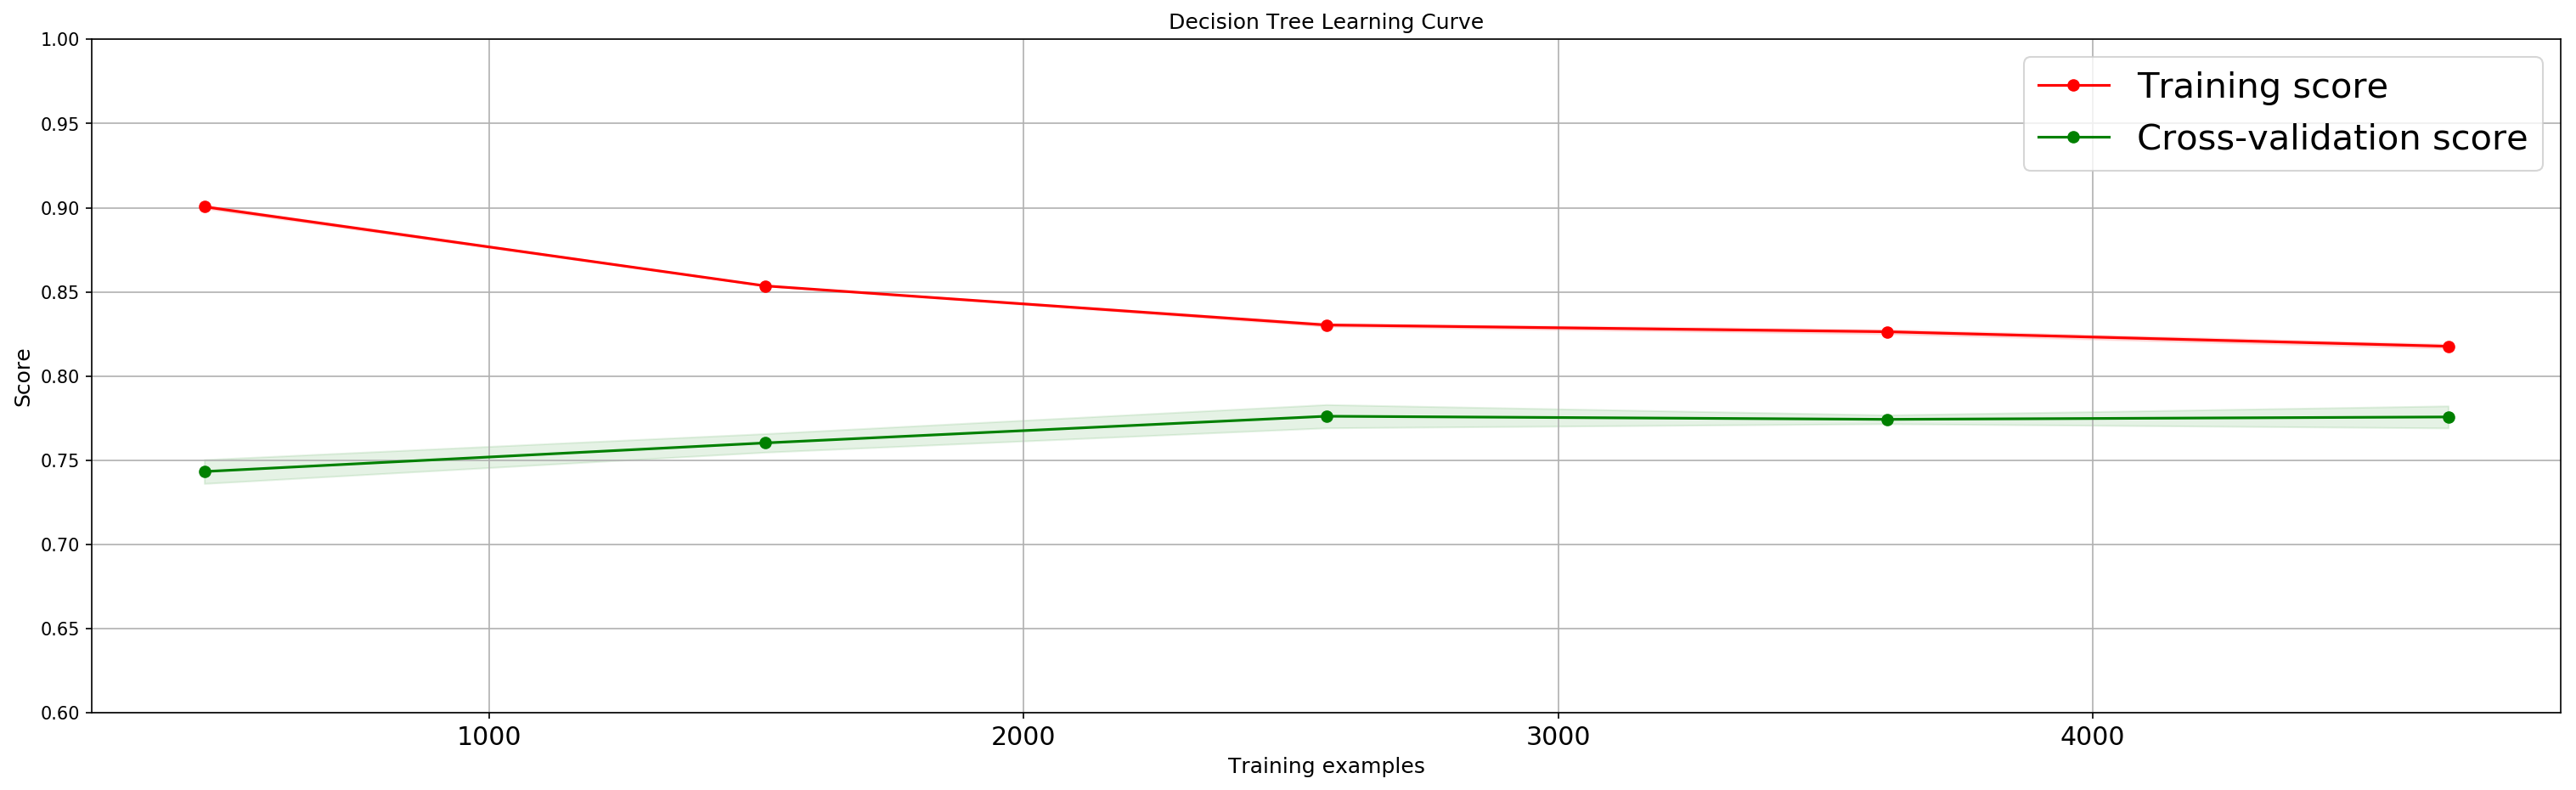

In [17]:
# Learning Curve - Plotting the model's performance on the training set.

plot_learning_curve(tree_clf, "Decision Tree Learning Curve", X_train, y_train, ylim=(0.6, 1.0), cv=3)   

In [18]:
# Cross Validated Accuracy - the proportion of prediction the model got right

cross_val_score(tree_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.77506427, 0.7840617 , 0.76801029])

In [19]:
y_train_pred_tree_clf = cross_val_predict(tree_clf, X_train, y_train, cv=3)

In [20]:
# Confusion Matrix - Gives insight into the type of errors being made by the model. 
# False Negatives (Prediction Negative and False), True Positives (Prediciton Positive and True)
# True Negatives (Prediction Negative and True), False Positives (Prediction Positive and False)

confusion_matrix(y_train, y_train_pred_tree_clf)

array([[4865,  450],
       [1120,  565]])

In [21]:
# Cross Validated Precision - the proportion of positive identifications that are actually correct split into 3 folds.

cross_val_score(tree_clf, X_train, y_train, cv=3, scoring="precision")

array([0.55096419, 0.59354839, 0.52339181])

In [22]:
# Cross Validated Recall - the proportion of actual positive that are identified correctly split into 3 folds.

cross_val_score(tree_clf, X_train, y_train, cv=3, scoring="recall")

array([0.35587189, 0.32740214, 0.32085561])

## Test Data

In [23]:
y_pred_tree_clf = tree_clf.predict(X_test)

<module 'matplotlib.pyplot' from '/Users/jsp22/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

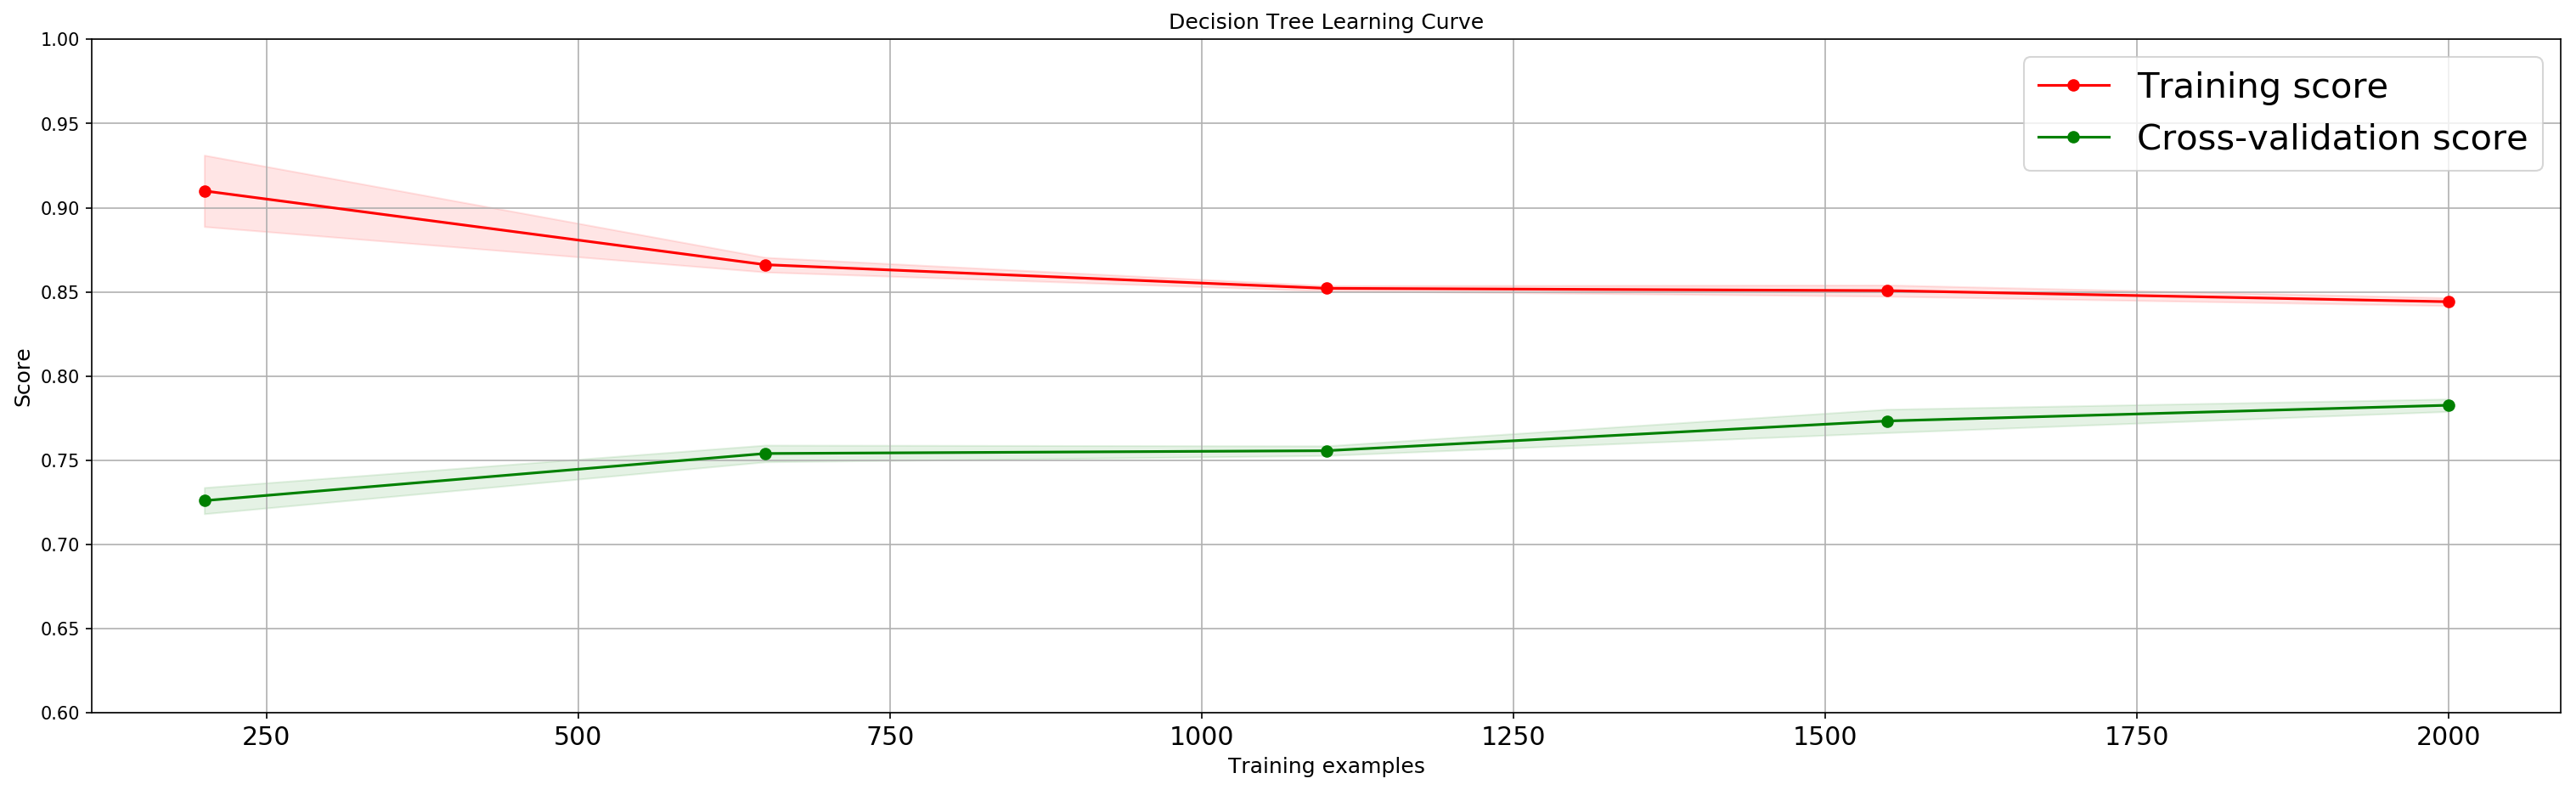

In [24]:
# Learning Curve - Plotting the model's performance on the training set.

plot_learning_curve(tree_clf, "Decision Tree Learning Curve", X_test, y_test, ylim=(0.6, 1.0), cv=3)   

In [25]:
# Confusion Matrix - Gives insight into the type of errors being made by the model. 
# False Negatives (Prediction Negative and False), True Positives (Prediciton Positive and True)
# True Negatives (Prediction Negative and True), False Positives (Prediction Positive and False)

confusion_matrix(y_test, y_pred_tree_clf)

array([[2140,  176],
       [ 450,  234]])

In [26]:
#Precision - the proportion of positive identifications that are actually correct.

precision_score(y_test, y_pred_tree_clf)

0.5707317073170731

In [27]:
# Recall - the proportion of actual positive that are identified correctly. 

recall_score(y_test, y_pred_tree_clf)

0.34210526315789475

## Support Vector Machine

In [28]:
# Now we train using a Support Vector Machine - a very powerful and versatile Machine Learning model, 
# capable of performing linear or nonlinear classification

svm_clf = SVC()

In [29]:
# We time how long it takes to fit the model

start_time = time()
svm_clf.fit(X_train, y_train)
print('Time elapsed: %.2fs' % (time()-start_time))

Time elapsed: 0.96s


In [30]:
# Cross Validated Accuracy - the proportion of prediction the model got right

cross_val_score(svm_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.78449015, 0.79005998, 0.7813036 ])

<module 'matplotlib.pyplot' from '/Users/jsp22/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

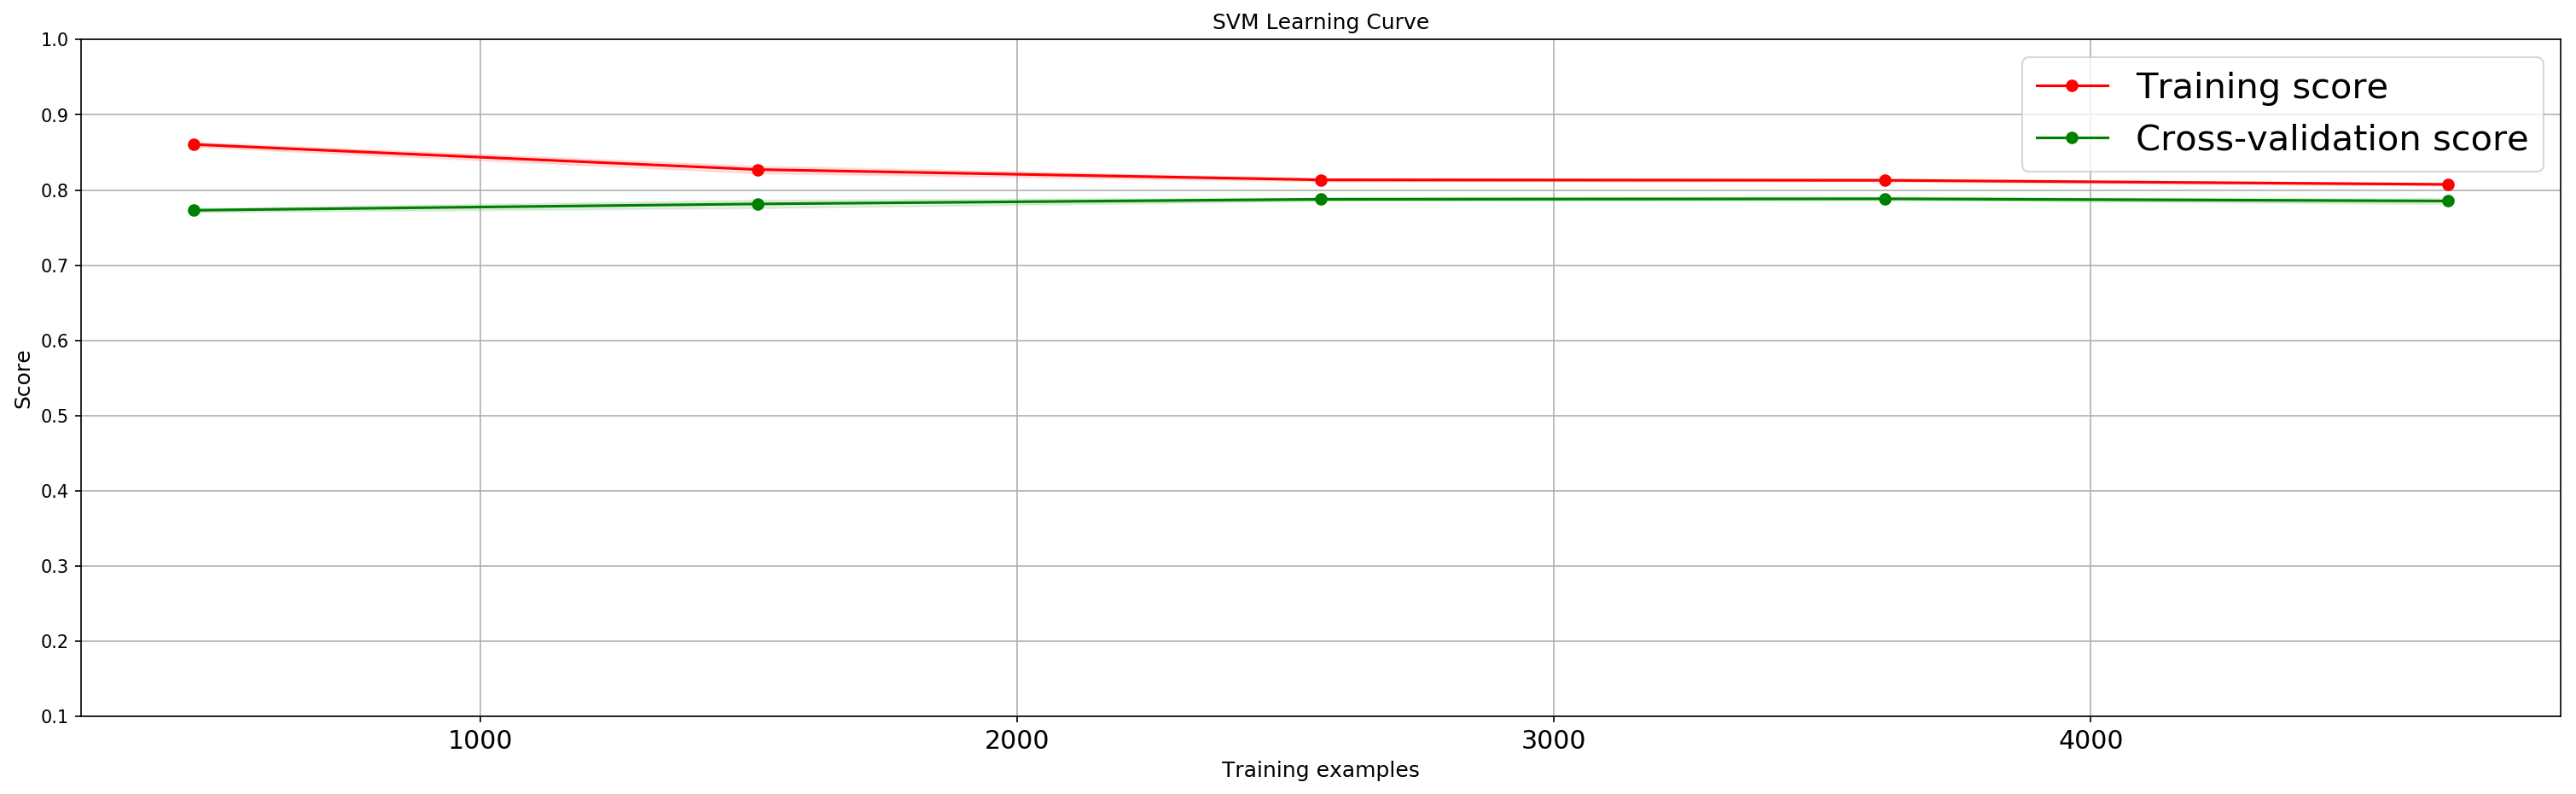

In [31]:
# Learning Curve - Plotting the model's performance on the training set.

plot_learning_curve(svm_clf, "SVM Learning Curve", X_train, y_train, ylim=(0.1, 1.0), cv=3)    

In [32]:
y_train_pred_svm_clf = cross_val_predict(svm_clf, X_train, y_train, cv=3)

In [33]:
# Confusion Matrix - Gives insight into the type of errors being made by the model. 
# False Negatives (Prediction Negative and False), True Positives (Prediciton Positive and True)
# True Negatives (Prediction Negative and True), False Positives (Prediction Positive and False)

confusion_matrix(y_train, y_train_pred_svm_clf)

array([[4963,  352],
       [1151,  534]])

In [34]:
# Cross Validated Precision - the proportion of positive identifications that are actually correct split into 3 folds.

cross_val_score(svm_clf, X_train, y_train, cv=3, scoring="precision")

array([0.58651026, 0.63533835, 0.59139785])

In [35]:
# Cross Validated Recall - the proportion of actual positive that are identified correctly split into 3 folds.

cross_val_score(svm_clf, X_train, y_train, cv=3, scoring="recall")

array([0.35587189, 0.30071174, 0.29411765])

## Test Data

In [36]:
y_pred_svm_clf = svm_clf.predict(X_test)

<module 'matplotlib.pyplot' from '/Users/jsp22/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

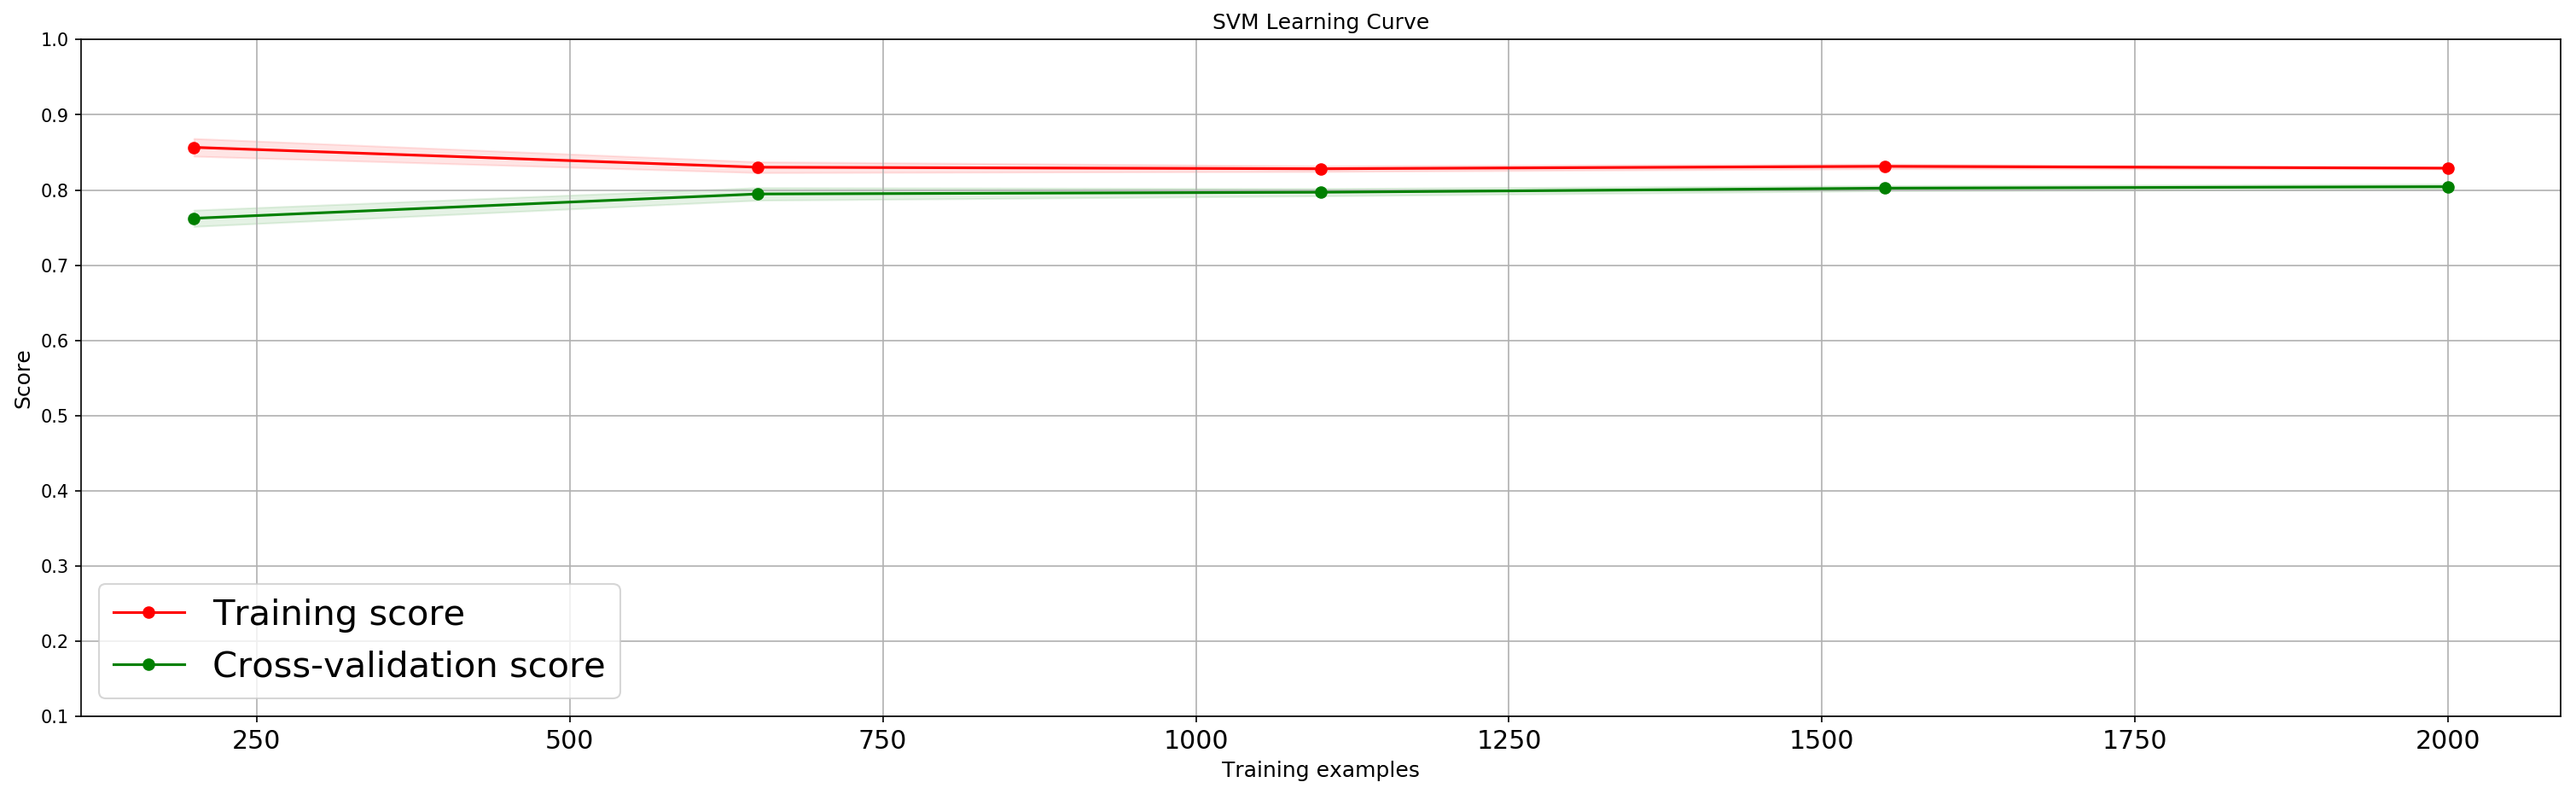

In [37]:
# Learning Curve - Plotting the model's performance on the test set.

plot_learning_curve(svm_clf, "SVM Learning Curve", X_test, y_test, ylim=(0.1, 1.0), cv=3)   

In [38]:
# Confusion Matrix - Gives insight into the type of errors being made by the model. 
# False Negatives (Prediction Negative and False), True Positives (Prediciton Positive and True)
# True Negatives (Prediction Negative and True), False Positives (Prediction Positive and False)

confusion_matrix(y_test, y_pred_svm_clf)

array([[2165,  151],
       [ 435,  249]])

In [39]:
#Precision - the proportion of positive identifications that are actually correct.

precision_score(y_test, y_pred_svm_clf)

0.6225

In [40]:
# Recall - the proportion of actual positive that are identified correctly. 

recall_score(y_test, y_pred_svm_clf)

0.36403508771929827

## Logistic Regression Classifier

In [41]:
# Now we train using a Logistic Regression Classifier - A model that generates a probability for each 
# possible discrete label value in classification problems by applying a sigmoid function to a linear prediction.

logit_clf = LogisticRegression(solver = 'lbfgs')

In [42]:
# We time how long it takes to fit the model

start_time = time()
logit_clf.fit(X_train, y_train)
print('Time elapsed: %.2fs' % (time()-start_time))

Time elapsed: 0.03s


In [43]:
# Cross Validated Accuracy - the proportion of prediction the model got right

cross_val_score(logit_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.78491859, 0.79048843, 0.78430532])

<module 'matplotlib.pyplot' from '/Users/jsp22/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

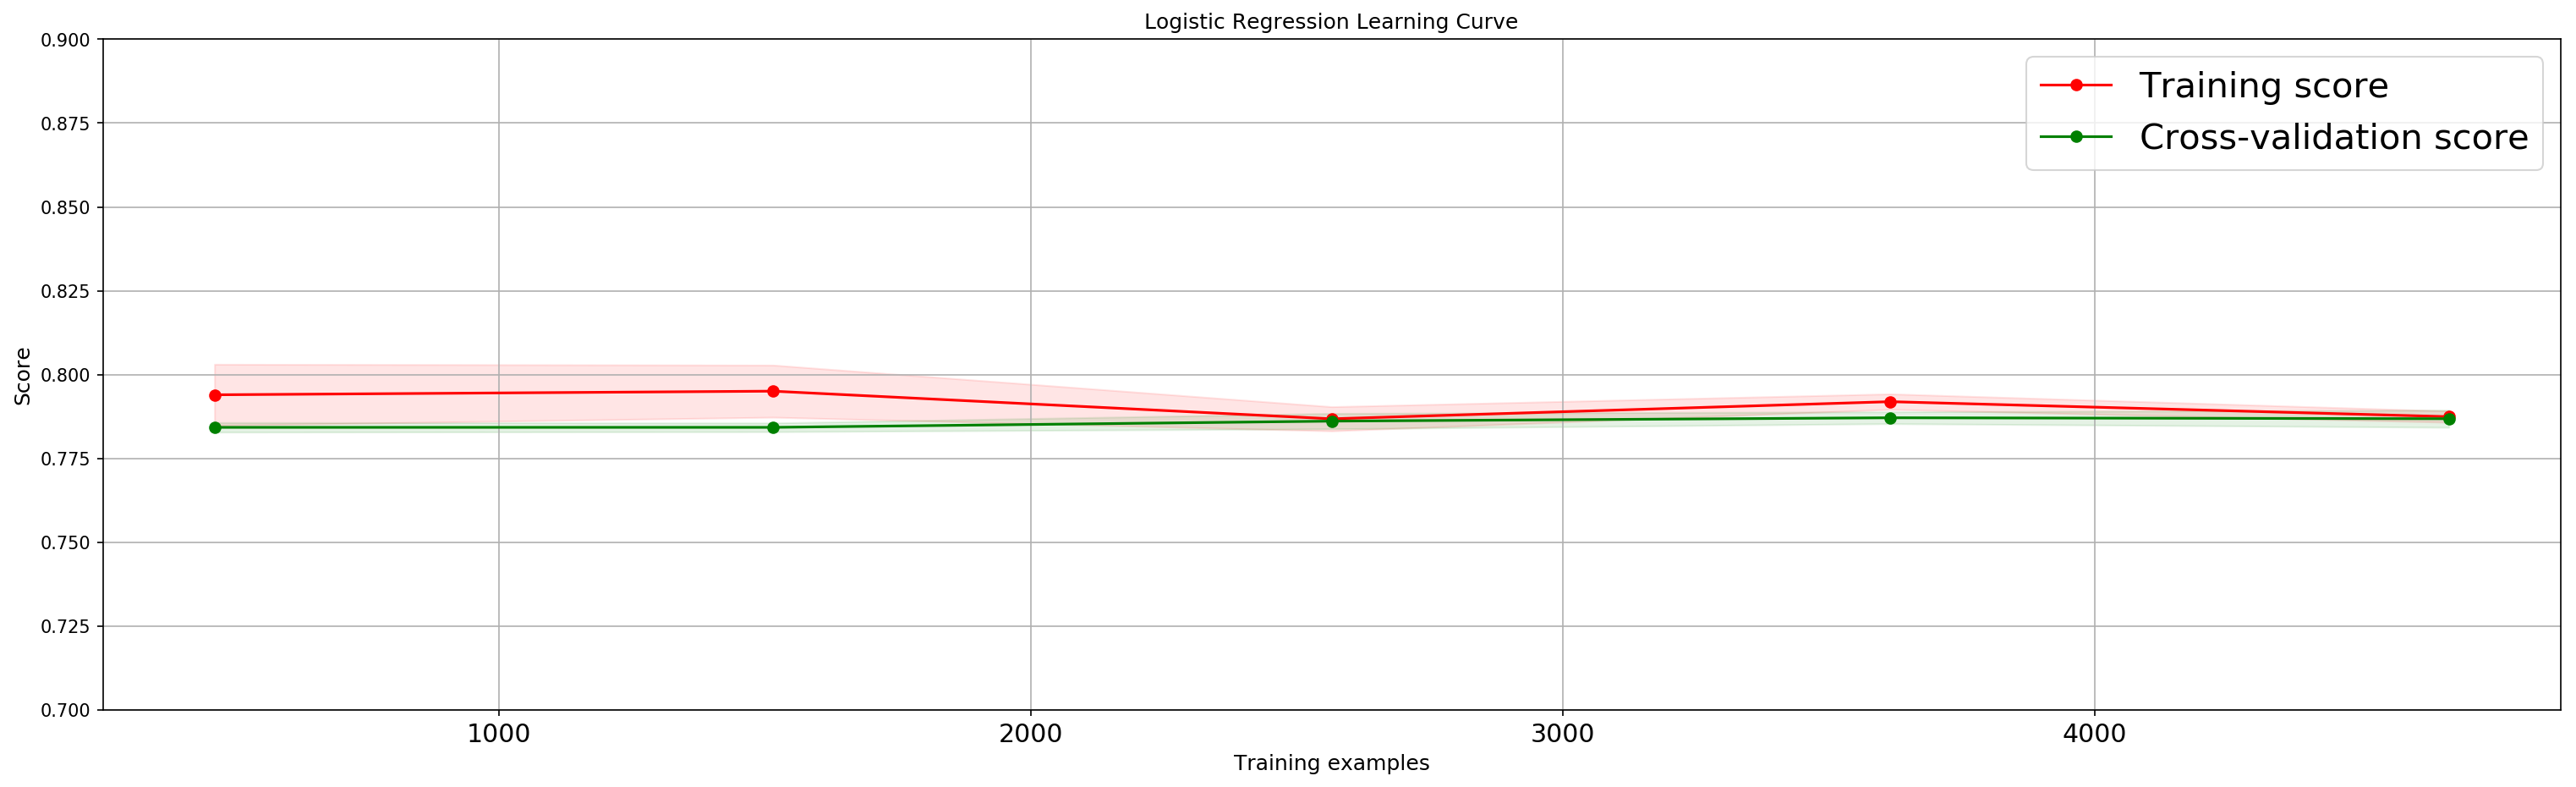

In [44]:
# Learning Curve - Plotting the model's performance on the training set.

plot_learning_curve(logit_clf, "Logistic Regression Learning Curve", X_train, y_train, ylim=(0.7, 0.9), cv=3)   

In [45]:
y_train_pred_logit_clf = cross_val_predict(logit_clf, X_train, y_train, cv=3)

In [46]:
# Confusion Matrix - Gives insight into the type of errors being made by the model. 
# False Negatives (Prediction Negative and False), True Positives (Prediciton Positive and True)
# True Negatives (Prediction Negative and True), False Positives (Prediction Positive and False)

confusion_matrix(y_train, y_train_pred_logit_clf)

array([[5008,  307],
       [1187,  498]])

In [47]:
# Cross Validated Precision - the proportion of positive identifications that are actually correct split into 3 folds.

cross_val_score(logit_clf, X_train, y_train, cv=3, scoring="precision")

array([0.61029412, 0.65145228, 0.59931507])

In [48]:
# Cross Validated Recall - the proportion of actual positive that are identified correctly split into 3 folds.

cross_val_score(logit_clf, X_train, y_train, cv=3, scoring="recall")

array([0.29537367, 0.27935943, 0.31194296])

## Test Data

In [49]:
y_pred_logit_clf = logit_clf.predict(X_test)

<module 'matplotlib.pyplot' from '/Users/jsp22/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

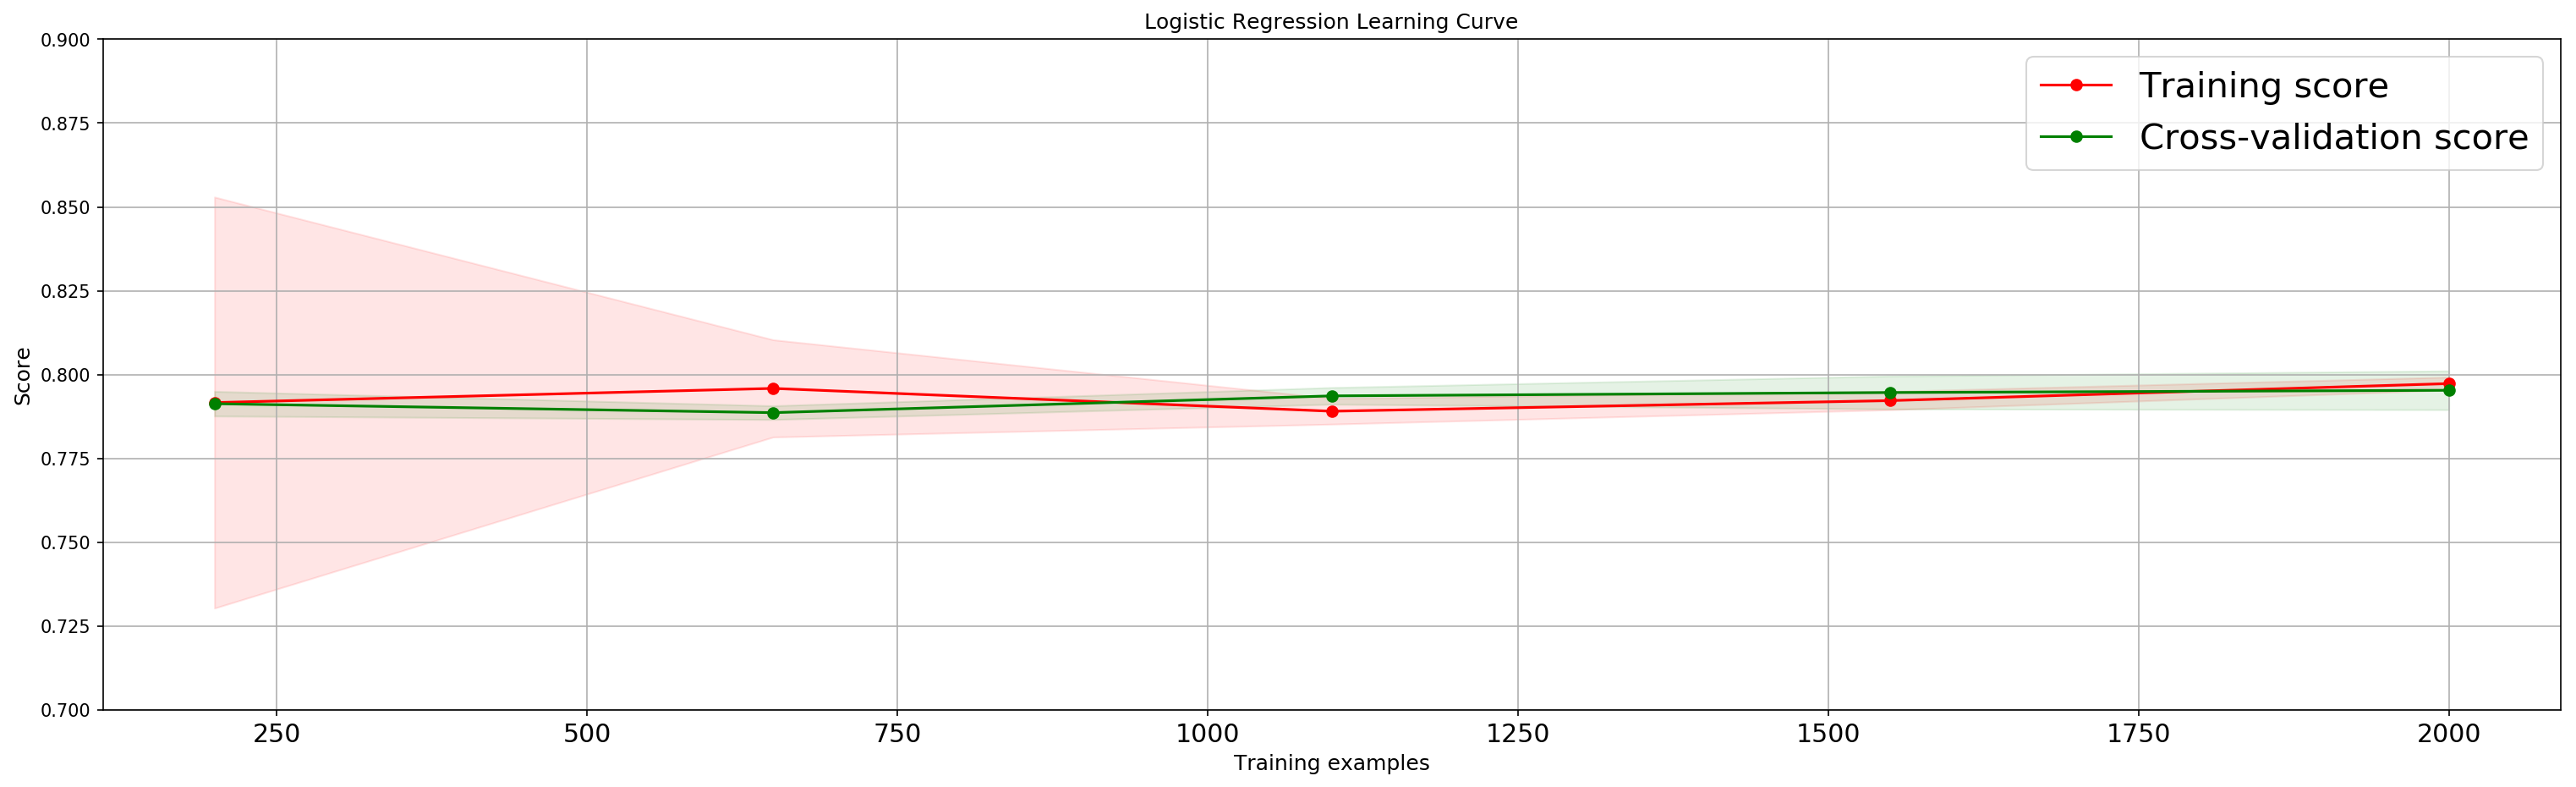

In [50]:
# Learning Curve - Plotting the model's performance on the test set.

plot_learning_curve(logit_clf, "Logistic Regression Learning Curve", X_test, y_test, ylim=(0.7, 0.9), cv=3)   

In [51]:
# Confusion Matrix - Gives insight into the type of errors being made by the model. 
# False Negatives (Prediction Negative and False), True Positives (Prediciton Positive and True)
# True Negatives (Prediction Negative and True), False Positives (Prediction Positive and False)

confusion_matrix(y_test, y_pred_logit_clf)

array([[2183,  133],
       [ 492,  192]])

In [52]:
#Precision - the proportion of positive identifications that are actually correct.

precision_score(y_test, y_pred_logit_clf)

0.5907692307692308

In [53]:
# Recall - the proportion of actual positive that are identified correctly. 

recall_score(y_test, y_pred_logit_clf)

0.2807017543859649

# Sex vs Salary

In [54]:
# drop columns won't be useful in analysis and prediction
data_sex = data.drop(['fnlwgt', 'education-num', 'education', 
                      'race', 'native-country', 'workclass',
                      'age', 'occupation', 'capital-gain', 'capital-loss',
                      'hours-per-week'], axis=1)

### Decreasing the sample size `n=1000` for ease of use

In [55]:
data_sex = data_sex.sample(n=10000)
data_sex.shape

(10000, 4)

In [56]:
data_sex.head()

,marital-status,relationship,sex,salary
12460,Never-married,Not-in-family,Female,1
6122,Widowed,Unmarried,Female,0
11538,Married-civ-spouse,Husband,Male,1
3700,Married-civ-spouse,Husband,Male,0
27243,Married-civ-spouse,Husband,Male,0


In [57]:
data_sex.tail()

,marital-status,relationship,sex,salary
12073,Married-civ-spouse,Husband,Male,0
1927,Never-married,Own-child,Male,0
14010,Never-married,Unmarried,Female,0
12377,Never-married,Unmarried,Male,1
8434,Never-married,Own-child,Male,0


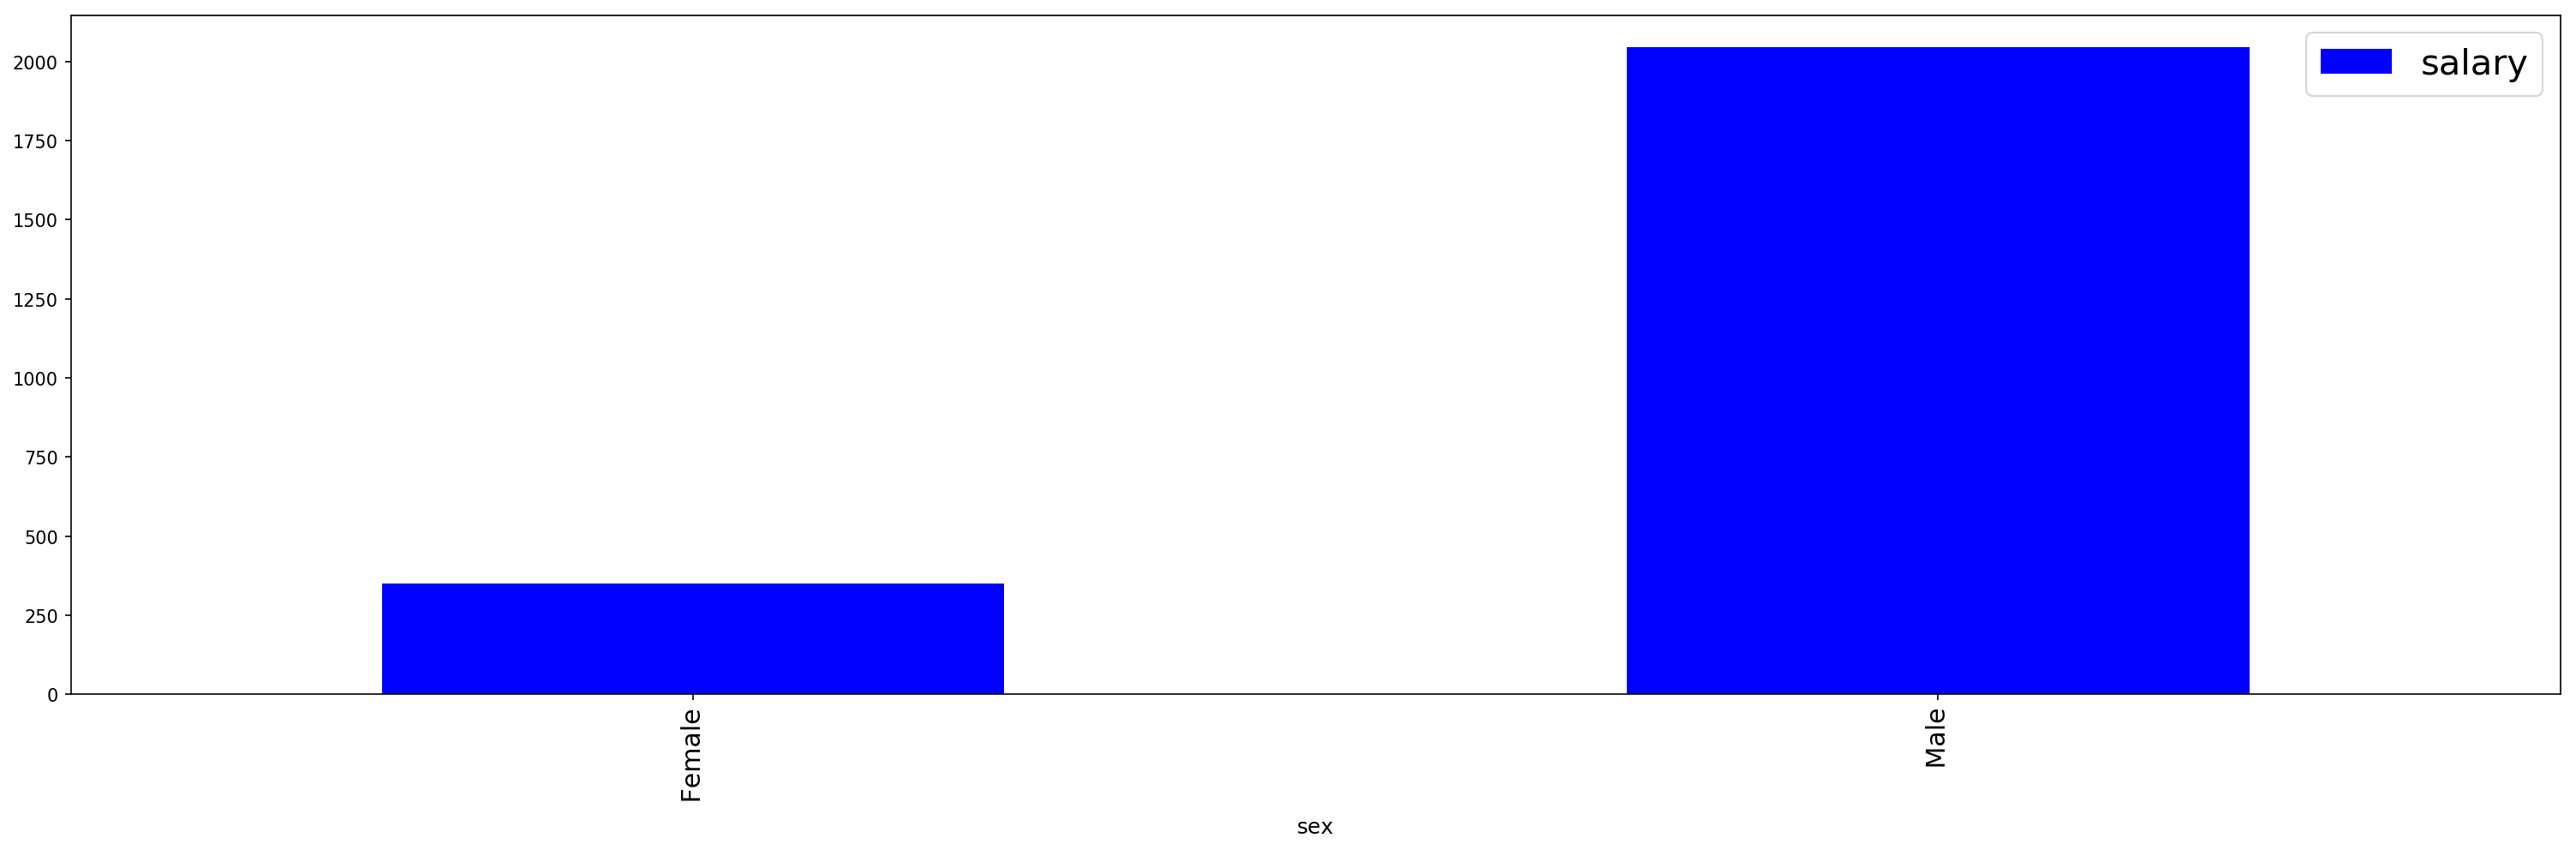

In [58]:
data_sex.groupby('sex').agg('sum')[['salary']].plot(kind='bar', figsize=(25, 7),
                                                          stacked=True, color=['b', 'r']);

In [59]:
data_sex["sex"].value_counts()

 Male      6655
 Female    3345
Name: sex, dtype: int64

### apply 1-hot encoding to categorical features `Sex` 

In [60]:
data_sex.dtypes

marital-status    object
relationship      object
sex               object
salary             int64
dtype: object

In [61]:
data_sex.columns

Index(['marital-status', 'relationship', 'sex', 'salary'], dtype='object')

In [62]:
data_sex = pd.get_dummies(data_sex, columns=['sex'], prefix = ['sex'])

In [63]:
data_sex.dtypes

marital-status    object
relationship      object
salary             int64
sex_ Female        uint8
sex_ Male          uint8
dtype: object

In [64]:
data_sex.describe()

,salary,sex_ Female,sex_ Male
count,10000.000000,10000.000000,10000.000000
mean,0.239300,0.334500,0.665500
std,0.426678,0.471839,0.471839
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000
75%,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000


## Train data

In [65]:
data_sex.shape

(10000, 5)

In [66]:
X_train = data_education.iloc[:7000]
X_train = X_train.drop(['salary'], axis=1)

X_test = data_education.iloc[7000:]
X_test = X_test.drop(['salary'], axis=1)

y_train = data_education.iloc[:7000]
y_train = y_train['salary']

y_test = data_education.iloc[7000:]
y_test = y_test['salary']

## Scale the data

In [67]:
std_scaler = StandardScaler()
X_train = std_scaler.fit_transform(X_train)
X_test = std_scaler.fit_transform(X_test)

## Create a Linear SVC and Learning Curve

In [68]:


svc_clf_1 = LinearSVC()
svc_clf_1.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [69]:
cross_val_score(svc_clf_1, X_train, y_train, cv=3, scoring="accuracy")
cross_val_score(svc_clf_1, X_train, y_train, cv=3, scoring="recall")
cross_val_score(svc_clf_1, X_train, y_train, cv=3, scoring="precision")

array([0.62770563, 0.66831683, 0.63346614])

<module 'matplotlib.pyplot' from '/Users/jsp22/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

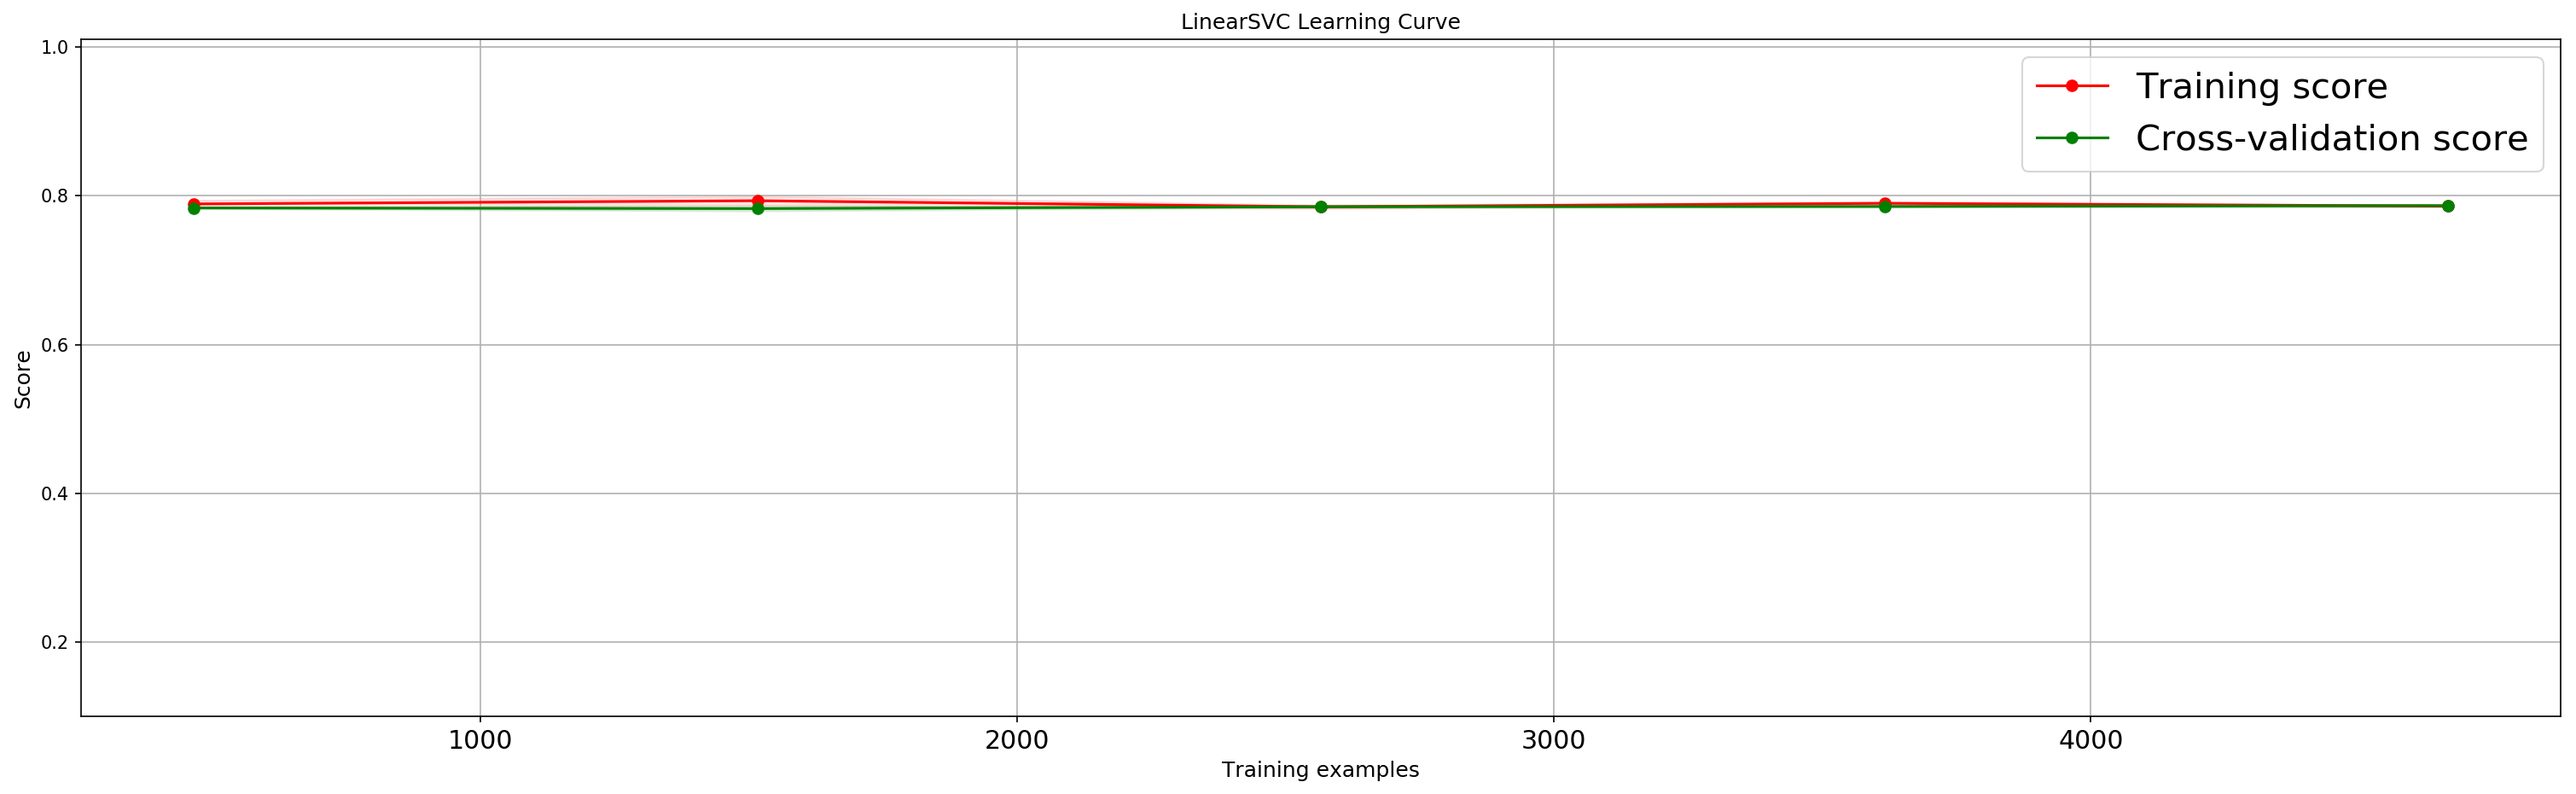

In [70]:
plot_learning_curve(svc_clf_1, "LinearSVC Learning Curve", X_train, y_train, ylim=(0.1, 1.01), cv=3)   

## Random Forest

In [71]:
clf = RandomForestClassifier()

parameters = {'n_estimators': [4, 6, 9], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]
             }


acc_scorer = make_scorer(accuracy_score)

grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

clf = grid_obj.best_estimator_

clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=4, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [73]:
predictions = clf.predict(X_test)
print(accuracy_score(y_test, predictions))

0.8033333333333333
